In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
today = datetime.today().strftime("%Y-%m-%d")

In [3]:
from urllib import request, parse
print("Today is", today)
# url =  "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-%s.xlsx" % today
url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
req =  request.Request(url) #, data=data) # this will make the method "POST"
resp = request.urlopen(req)
resp = resp.read()

Today is 2020-03-29


In [4]:
outfile = "ECDC_%s.csv" %today

In [5]:
with open(outfile, 'wb') as out_cvs:
    out_cvs.write(resp)

data= pd.read_csv(outfile, encoding='mac_roman')

data['dateRep'] = pd.to_datetime(data.dateRep)
data.rename(columns={'dateRep' : 'date'}, inplace=True)


data['geoId'] = (data.geoId)

data = data.sort_values(['geoId','date'])

In [6]:
cols_cum = ['cases','deaths']

for col in cols_cum:
    data[col+'_cum'] = data.groupby('geoId')[col].cumsum()

In [7]:
data = data[data.date <= today]

data = data.set_index('date')

In [8]:
import matplotlib
from matplotlib import pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


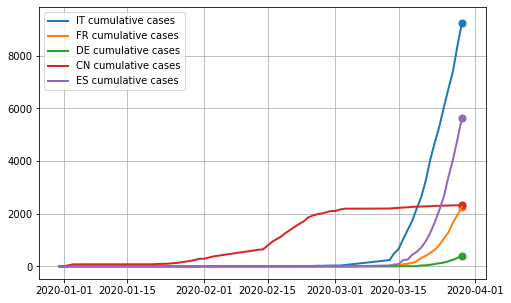

In [9]:
fig,ax = plt.subplots(figsize=(8,5))

for cntry in ['IT','FR','DE','CN','ES']:
    plt_data = data[data.geoId==cntry]
    latest_data = plt_data.loc[plt_data.index==max(plt_data.index)]
    ax.plot(plt_data.index, "deaths_cum", data=plt_data, label=cntry+' cumulative cases', linewidth=2)
    ax.scatter(x=latest_data.index, y=latest_data.deaths_cum, s=50)
    
ax.legend()
ax.grid()   


In [10]:
data['cases_cum_lag'] = data.groupby('geoId')['cases_cum'].shift(-1)
data['deaths_cum_lag'] = data.groupby('geoId')['deaths_cum'].shift(-1)

In [11]:
cases_diff = data.groupby('geoId').apply(lambda x: x.cases_cum.shift(-1) - x.cases_cum).reset_index()

In [12]:
lag_dict = {}
for cntry in data.geoId.unique():
    #df = cases_diff[cases_diff.geoId == cntry].set_index('date')
    df = data[data.geoId==cntry]#.set_index('date')
    #df = df[df.index > '2020-02-20'].deaths >50
    df = df.deaths >20
#     df = df.cases_cum > 200
    try:
        lag_date = df[df==True].index[0]
        tmp = {cntry : lag_date}
        lag_dict.update(tmp)
        print(cntry, 'OK')
    except:
        print(cntry, 'Not above threshold')

AD Not above threshold
AE Not above threshold
AF Not above threshold
AG Not above threshold
AI Not above threshold
AL Not above threshold
AM Not above threshold
AO Not above threshold
AR Not above threshold
AT Not above threshold
AU Not above threshold
AW Not above threshold
AZ Not above threshold
BA Not above threshold
BB Not above threshold
BD Not above threshold
BE OK
BF Not above threshold
BG Not above threshold
BH Not above threshold
BJ Not above threshold
BM Not above threshold
BN Not above threshold
BO Not above threshold
BR OK
BS Not above threshold
BT Not above threshold
BY Not above threshold
BZ Not above threshold
CA Not above threshold
CD Not above threshold
CF Not above threshold
CG Not above threshold
CH OK
CI Not above threshold
CL Not above threshold
CM Not above threshold
CN OK
CO Not above threshold
CR Not above threshold
CU Not above threshold
CV Not above threshold
CW Not above threshold
CY Not above threshold
CZ Not above threshold
DE OK
DJ Not above threshold
DK N

In [13]:
#lag_dict['CN'] = pd.to_datetime('2019-12-31')

In [14]:
for cntry in ['IT','FR','DE','CN','ES']:
    lag_date = lag_dict[cntry]
    start_date = min(data.index)
#     len_cntry = data.loc[(data.index>=lag_date) & (data.index < today) & (data.geoId==cntry)].shape[0]
    print("country = ", cntry)
    print("lag_date: ", lag_date)
    data.loc[(data.index>=start_date) & (data.index < today) & (data.geoId==cntry), 't'] = \
            data.loc[(data.index>=start_date) & (data.index < today) & (data.geoId==cntry)].index-lag_date

country =  IT
lag_date:  2020-03-13 00:00:00
country =  FR
lag_date:  2020-03-16 00:00:00
country =  DE
lag_date:  2020-03-20 00:00:00
country =  CN
lag_date:  2020-01-02 00:00:00
country =  ES
lag_date:  2020-03-13 00:00:00


In [17]:
data_main = data[(data.geoId.isin(['IT','FR','DE','CN','ES']))].copy()

data_main = data_main[['geoId','cases','deaths','cases_cum','deaths_cum','t']]

data_main['t'] = data_main.t.dt.days

In [18]:
data_main['cases_mav'] = data_main.cases_cum.rolling(3).mean()
data_main['deaths_mav'] = data_main.deaths_cum.rolling(3).mean()

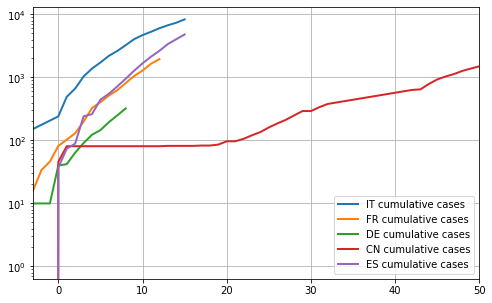

In [22]:
fig,ax = plt.subplots(figsize=(8,5))

for cntry in ['IT','FR','DE','CN','ES']:
    plt_data = data[data.geoId==cntry]
#     latest_data = plt_data.loc[plt_data.index==max(plt_data.index)]
    ax.plot(plt_data.t.dt.days, "deaths_cum", data=plt_data, label=cntry+' cumulative cases', linewidth=2)
#     ax.scatter(x=latest_data.index, y=latest_data.deaths_cum, s=50)
    plt.xlim(-3,50)
    plt.yscale('log')
ax.legend()
ax.grid()   

In [54]:
plt_data.columns

Index(['day', 'month', 'year', 'cases', 'deaths', 'countriesAndTerritories',
       'geoId', 'countryterritoryCode', 'popData2018', 'cases_cum',
       'deaths_cum', 'cases_cum_lag', 'deaths_cum_lag', 't'],
      dtype='object')

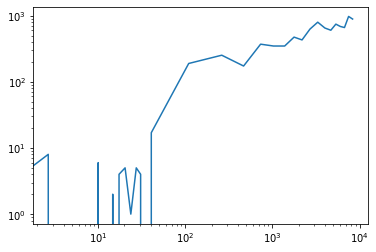

In [79]:
fig,ax = plt.subplots()

plt_data = data_main[data_main.geoId=='IT']
ax.plot("deaths_mav", "deaths", data=plt_data)
plt.yscale('log')
plt.xscale('log')